In [1]:
import numpy as np
import copy
from scipy import misc
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CyclicLR, ReduceLROnPlateau, LinearLR, ExponentialLR
import random
from torch.autograd.functional import jacobian#, hessian
# import AUTOGRAD.FUNCTIONAL.JACOBIAN as jacobian
import time
import os
path = os.getcwd()
import json
from visuals import display_it

import matplotlib as mpl
%matplotlib inline
# from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt # type: ignore
mpl.rcParams['legend.fontsize'] = 10
torch.set_default_dtype(torch.float64)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
from functions import ChesneyScott, exp_solution
from derivation import Grad, Grad_Hess
from visuals import display_it
from equation import semilinear
from coeff import OU_drift_semi, custom_diff, zero_discount, f_driver, exponential_terminal

In [3]:


# class display_it(object):
#     def __init__(self,eqn,**kwargs):
#         t = 0# default time. Change it if kwargs kick in later.
                
#         if eqn.dim == 2:
#             f = plt.figure(figsize=(6,6),dpi=300);
#             ax = f.add_subplot(111, projection='3d')
#             ax.set_xlabel('wealth')
#             ax.set_ylabel('volatility');
            
            
#             steps =100
#             x = torch.linspace(eqn.params['start'].item(),eqn.params['end'].item(),steps=steps)
#             y = torch.linspace(eqn.params['start'].item(),eqn.params['end'].item(),steps=steps)
#             xy = torch.cartesian_prod(x,y)
#             X, Y = torch.meshgrid(x, y, indexing='ij')
#             v_T = eqn.terminal(xy).detach().reshape(steps,steps).squeeze(-1)
#             ax.plot_surface(X.numpy(),Y.numpy(),v_T.numpy(),alpha=0.5,label='Terminal',color='gray');
#             txy = torch.cat((torch.zeros(xy.shape[0],1),xy),axis=1)
#             if kwargs:
#                 if 't' in kwargs.keys():
#                     t = kwargs['t']
#                     txy = torch.cat((t*torch.ones(xy.shape[0],1),xy),axis=1)
#                 else:
#                     v = eqn.Y0(xy).detach().reshape(steps,steps).squeeze(-1)
#                     ax.plot_surface(X.numpy(),Y.numpy(),v.numpy(),alpha=0.5,label="approximation",color='b');
#             else:
#                 v = eqn.Y0(xy).detach().reshape(steps,steps).squeeze(-1)
#                 ax.plot_surface(X.numpy(),Y.numpy(),v.numpy(),alpha=0.5,label="approximation",color='b');

            
#             vt = eqn.Yt(txy).detach().reshape(steps,steps).squeeze(-1)
#             ax.plot_surface(X.numpy(),Y.numpy(),vt.numpy(),alpha=0.5,label="fitted",color='r');
            
#             if kwargs:
#                 if 'closed_form' in kwargs.keys():
#                     sol = kwargs['closed_form']
#                     v_c = sol(txy).detach().reshape(steps,steps).squeeze(-1)                
#                     ax.plot_surface(X.numpy(),Y.numpy(),v_c.numpy(),alpha=0.5,label='closed-form',color='g');
 
            
#             legend_loc=(0.0,0.8)
#             if kwargs:
#                 if 'zlim' in kwargs.keys():
#                     ax.set_zlim(kwargs['zlim'])
#                 if 'legend_loc' in kwargs.keys():
#                     legend_loc = kwargs['legend_loc']


#             ax.legend(loc=legend_loc)  
#             f.suptitle(r'At time t={:.2f}'.format(t))

#             # path = os.path.join(kwargs['path'],"figure_"+str(t)+"_.png")
#             # if 'path' in kwargs:
#             #     plt.savefig(path)
#             # plt.show();
                
#         if kwargs:
#             data = eqn.params['start'].item()+(eqn.params['end'].item()-eqn.params['start'].item())*torch.rand(2**14,eqn.dim)
#             if 't' in kwargs.keys():
#                 t = kwargs['t']
#                 tdata = torch.cat((t*torch.ones(data.shape[0],1),data),axis=1)
#                 v_t = eqn.Yt(tdata).detach().squeeze(-1)
#                 if 'closed_form' in kwargs.keys():
#                     sol = kwargs['closed_form']
#                     v_c = sol(tdata).detach().squeeze(-1)
#                     print(r'The $L^2$ distance between the fitted value function at time {:.2f} and closed-form is  {:.3E}.'.format(t,pow(v_c-v_t,2).mean()))
#                     # eqn.params['L2_fit_cf'] = [t,pow(v_c-v_t,2).mean()]
#             else:
#                 v_0 = eqn.Y0(data).detach().squeeze(-1)        
#                 tdata = torch.cat((torch.zeros(data.shape[0],1),data),axis=1)
#                 v_t = eqn.Yt(tdata).detach().squeeze(-1)     
#                 if 'closed_form' in kwargs.keys():
#                     sol = kwargs['closed_form']
#                     v_c = sol(tdata).detach().squeeze(-1)              
#                     print(r'The $L^2$ distance between the fitted value function at time 0 and closed-form is  {:.3E}.'.format(pow(v_c-v_t,2).mean()))
#                     print(r'The $L^2$ distance between the approximated value function at time 0 and closed-form for optimal $\sigma$  is  {:.3E}.'.format(pow(v_c-v_0,2).mean()))
#                 # eqn.params['L2_fit_cf'] = [0.0,pow(v_c-v_t,2).mean()]
#                 # eqn.params['L2_v0_cf'] = [0.0,pow(v_c-v_0,2).mean()]
        
                    
               

        


In [4]:
'''Germain, Pham, Warin parameters'''
pde_params={'dim':2,
            'kappa':torch.tensor([0.,1.,0.8,0.6,0.4,0.5,0.3,0.2,0.1,0.7]).to(device), # The first kappa=0 because the drift of wealth process is zero
            'theta':torch.tensor([0.,0.4,0.2,0.3,0.4,0.5,0.4,0.3,0.2,0.1]).to(device),
            # 'nu':torch.tensor([0.02,0.015,0.11,0.12,0.01,0.013,0.14,0.14,0.01]).to(device), #Hung's coefficient
            'nu':torch.tensor([0.,0.2,0.15,0.11,0.12,0.1,0.13,0.14,0.14,0.1]).to(device), # we do not like vanishing diffusion coefficient
            # 'lb':torch.tensor([0.,0.15,0.11,0.12,0.13,0.15,0.11,0.12,0.13,0.15]).to(device),   Hung's params
            'lb':torch.tensor([0.,1.5,1.11,0.12,0.13,0.15,0.11,0.12,0.13,0.15]).to(device), # New params Make closed form solution more sensitive to time
            # 'lb':torch.tensor([0.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]).to(device), # CS test
            'rho':torch.tensor([0.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]).to(device),
            'eta':torch.tensor([.5]).to(device),
            'T': 1.,#torch.tensor([1.]).to(device),
            }
'''Our parameters'''
# pde_params={'dim':2,
#             'kappa':torch.tensor([0.,1.,0.8,0.6,0.4,0.5,0.3,0.2,0.1,0.7]).to(device), # The first kappa=0 because the drift of wealth process is zero
#             'theta':torch.tensor([0.,0.1,0.2,0.3,0.4,0.5,0.4,0.3,0.2,0.1]).to(device),
#             # 'nu':torch.tensor([0.02,0.015,0.11,0.12,0.01,0.013,0.14,0.14,0.01]).to(device), #Hung's coefficient
#             'nu':torch.tensor([0.2,0.15,0.11,0.12,0.1,0.13,0.14,0.14,0.1]).to(device), # we do not like vanishing diffusion coefficient
#             # 'lb':torch.tensor([0.,0.15,0.11,0.12,0.13,0.15,0.11,0.12,0.13,0.15]).to(device),   Hung's params
#             'lb':torch.tensor([0.,1.15,1.11,0.12,0.13,0.15,0.11,0.12,0.13,0.15]).to(device), # New params Make closed form solution more sensitive to time
#             'rho':torch.tensor([0.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]).to(device),
#             'eta':torch.tensor([1.]).to(device),
#             'T': 1.,#torch.tensor([1.]).to(device),
#             }

'Our parameters'

In [5]:
cs = ChesneyScott(pde_params)
cs.theta,cs.nu,cs.lb,cs.kappa,cs.eta

(tensor([0.0000, 0.4000]),
 tensor([0.0000, 0.2000]),
 tensor([0.0000, 1.5000]),
 tensor([0., 1.]),
 tensor([0.5000]))

In [6]:
input = torch.Tensor([[0.,1.,pde_params['theta'][1]],[0.,1.,.195865],[0.,1.,.2]])
input

tensor([[0.0000, 1.0000, 0.4000],
        [0.0000, 1.0000, 0.1959],
        [0.0000, 1.0000, 0.2000]])

In [7]:
cs_val = cs(input)-1
print("{:.8f}, {:.7f}, {:.7f}".format(cs_val[0].item(),cs_val[1].item(),cs_val[2].item()))

-0.50156831, -0.5513028, -0.5504669


In [8]:
torch.sqrt(torch.pow(cs.kappa,2)+ torch.pow(cs.nu*cs.lb,4)),torch.sqrt(torch.pow(cs.kappa,2)+ torch.pow(cs.nu*cs.lb,4))

(tensor([0.0000, 1.0040]), tensor([0.0000, 1.0040]))

In [9]:
lb_norm2 = -0.5*torch.pow(pde_params['lb'][:pde_params['dim']],2).sum()
merton = exp_solution(pde_params,lb_norm2)

In [10]:
merton_val = merton(input)-1
print("{:.7f}, {:.7f}, {:.7f}".format(merton_val[0].item(),merton_val[1].item(),merton_val[2].item()))

-0.1969117, -0.1969117, -0.1969117


In [11]:
t0 = time.time()
num_samples = 2**16
num_time_intervals = 30
max_dim = 10
size = num_samples* max_dim * num_time_intervals
iid = torch.randn(size=[size]).to(device)
print("It takes {:.0f} ms to generate {:,} iid samples.".format(round(1000*(time.time()-t0),6),size))

It takes 194 ms to generate 19,660,800 iid samples.


In [12]:
sim_params={'num_samples':2**12,
        'num_time_intervals': 10,
        'iid':iid,
        'start' : torch.tensor([0.9]),  
        'end' : torch.tensor([1.1]),
        'num_neurons':4
        }

In [13]:
m = OU_drift_semi(pde_params)
optimal_diff = m.lb_norm/pde_params['eta']
semi_diff_opt = custom_diff(pde_params,optimal_diff)
k = zero_discount(pde_params)
g = exponential_terminal(pde_params)
F = f_driver(pde_params)

/Users/fahim/Documents/GitHub/Deep-Schemes-for-Control/coeff.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.nu = torch.tensor(params['nu'][0:self.dim]).clone().detach().to(device)
/Users/fahim/Documents/GitHub/Deep-Schemes-for-Control/coeff.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.kappa = torch.tensor(params['kappa'][0:self.dim]).clone().detach().to(device)
/Users/fahim/Documents/GitHub/Deep-Schemes-for-Control/coeff.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.theta = torch.tensor(params['theta'][

In [14]:
semi = semilinear(semi_diff_opt,m,F,k,g,pde_params,sim_params)

/Users/fahim/Documents/GitHub/Deep-Schemes-for-Control/samplepaths.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(sim['start']).clone().detach().to(device)
/Users/fahim/Documents/GitHub/Deep-Schemes-for-Control/samplepaths.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(sim['end']).clone().detach().to(device)


In [15]:
semi.params['start'].item()

0.9

In [16]:
semi.train(lr=1e-2,delta_loss=1e-10,max_num_epochs=10000)

At epoch 1, mean loss is 1.29E+02.
Training this epoch takes 21.75 ms. So far: 394.06 ms in training.


The $L^2$ distance between the fitted value function at time 0 and closed-form is  1.279E-03.
The $L^2$ distance between the approximated value function at time 0 and closed-form for optimal $\sigma$  is  1.210E-03.


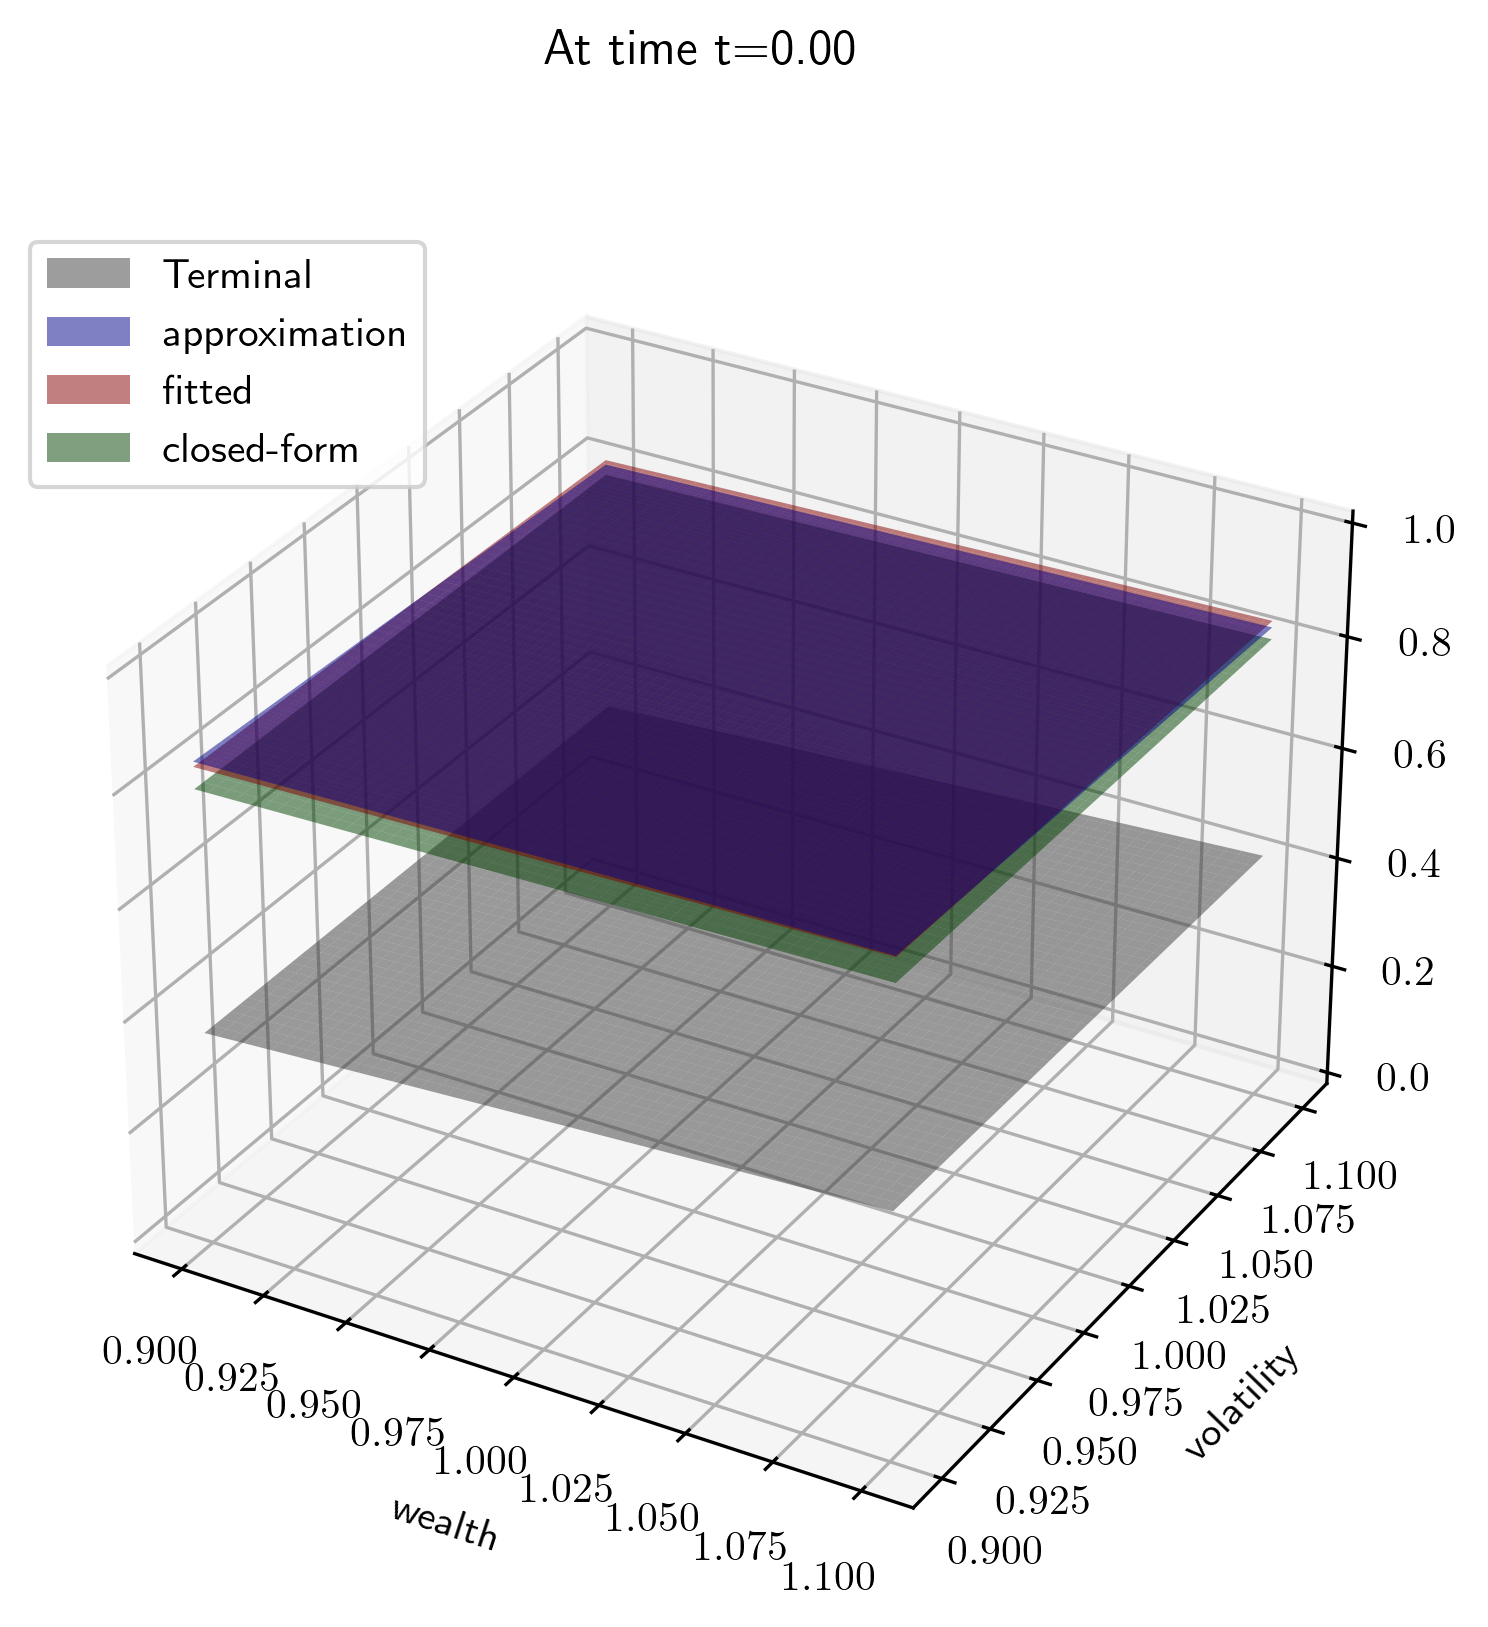

In [ ]:
alpha = -0.5*torch.pow(pde_params['lb'][0:pde_params['dim']],2).sum()
sol_semi = exp_solution(pde_params,alpha)
display_it(semi,closed_form=sol_semi,zlim=[0.0,1.0]);

In [ ]:
torch.abs((semi.Y0(torch.tensor([[1.,0.]]))-merton(torch.tensor([[0.,1.,0.]])))/merton(torch.tensor([[0.,1.,0.]])))*100

tensor([[7.0326]], grad_fn=<MulBackward0>)

In [ ]:
m = OU_drift_semi(pde_params)
optimal_cs_diff = lambda x: torch.sqrt(torch.pow(m.lb*x[:,1:],2).sum(axis=1))/pde_params['eta']
semi_diff_opt = custom_diff(pde_params,optimal_cs_diff)
k = zero_discount(pde_params)
g = exponential_terminal(pde_params)
F = f_driver(pde_params,ChesneyScott=True)

/Users/fahim/Documents/GitHub/Deep-Schemes-for-Control/coeff.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.nu = torch.tensor(params['nu'][0:self.dim]).clone().detach().to(device)
/Users/fahim/Documents/GitHub/Deep-Schemes-for-Control/coeff.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.kappa = torch.tensor(params['kappa'][0:self.dim]).clone().detach().to(device)
/Users/fahim/Documents/GitHub/Deep-Schemes-for-Control/coeff.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.theta = torch.tensor(params['theta'][

In [ ]:
optimal_cs_diff(input),input,m.lb,m.lb*input[:,1:]/m.eta

(tensor([1.2000, 0.5876, 0.6000]),
 tensor([[0.0000, 1.0000, 0.4000],
         [0.0000, 1.0000, 0.1959],
         [0.0000, 1.0000, 0.2000]]),
 tensor([0.0000, 1.5000]),
 tensor([[0.0000, 1.2000],
         [0.0000, 0.5876],
         [0.0000, 0.6000]]))

In [ ]:
semics = semilinear(semi_diff_opt,m,F,k,g,pde_params,sim_params)

/Users/fahim/Documents/GitHub/Deep-Schemes-for-Control/samplepaths.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(sim['start']).clone().detach().to(device)
/Users/fahim/Documents/GitHub/Deep-Schemes-for-Control/samplepaths.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(sim['end']).clone().detach().to(device)


In [ ]:
semics.train(lr=1e-2,delta_loss=1e-10,max_num_epochs=10000)

At epoch 1, mean loss is 1.72E+01.
Training this epoch takes 15.98 ms. So far: 16.31 ms in training.
At epoch 3333, mean loss is 2.15E-01.
Training this epoch takes 11.1 ms. So far: 43,356.54 ms in training.
At epoch 6666, mean loss is 1.47E-01.
Training this epoch takes 13.94 ms. So far: 86,788.67 ms in training.
At epoch 9999, mean loss is 1.31E-01.
Training this epoch takes 10.58 ms. So far: 130,500.15 ms in training.
Training took 10000 epochs and 130,513.77 ms and the final loss is 1.31E-01.


In [ ]:
semics.Yt(torch.tensor([[0.,1.,2.]])),semics.Y0(torch.tensor([[1.,2.]]))

(tensor([[2.0006]], grad_fn=<AddmmBackward0>),
 tensor([[0.9348]], grad_fn=<AddmmBackward0>))

In [ ]:
display_it(semics,closed_form=cs);

NameError: name 'semics' is not defined